In [1]:
from pyrocko import util, model, io, trace, moment_tensor, gmtpy
from pyrocko import pz
from pyrocko import orthodrome as od
from pyrocko.io import quakeml
from pyrocko.io import stationxml as fdsn
from pyrocko.client import catalog
from pyrocko.automap import Map
import pyrocko.moment_tensor as pmt
from seiscloud import plot as scp
from seiscloud import cluster as scc
import numpy as num
import os, sys, re, math, shutil
import matplotlib.pyplot as plt
from matplotlib import collections  as mc
from matplotlib import dates
import datetime
import urllib.request
from pyrocko.plot.gmtpy import GMT
from zoneinfo import ZoneInfo

#obspy
from obspy import read_inventory
from obspy.core.stream import Stream
from obspy.clients.fdsn.client import Client
from obspy import UTCDateTime
import pytz

In [2]:
workdir='../'
catdir =  os.path.join(workdir,'CAT')
meta_datadir=os.path.join(workdir,'META_DATA')
datadir=os.path.join(workdir,'DATA')

In [ ]:
catname = os.path.join(catdir, 'catologue_flegrei_new_mag2_5.pf')

cat = model.load_events(catname)
print('Number of events:', len(cat))

In [3]:
client=Client('INGV')
stations_name=os.path.join(meta_datadir, 'stations_flegrei_INGV.xml')
stations=read_inventory(stations_name)                                 #read

print(stations)

Inventory created at 2024-01-16T14:42:48.667000Z
	Created by: INGV-ONT WEB SERVICE: fdsnws-station | version: 1.1.57
		    /exist/apps/fdsn-station/fdsnws/station/1/query?starttime=2014-01-...
	Sending institution: eXistDB (INGV-ONT)
	Contains:
		Networks (3):
			IV, IX, ZM
		Stations (49):
			IV.CAAM (Accademia Aeronautica Pozzuoli)
			IV.CAFL (Arco Felice)
			IV.CAWE (Astroni Ovest - Stazione Osservatorio Vesuviano)
			IV.CBAC (Campi Flegrei, Castello di Baia - Stazione Osservatorio Vesu)
			IV.CCAP (Capo Posillipo C. acqisiz. - Stazione Osservatorio Vesuviano)
			IV.CFMN (Monte Nuovo)
			IV.CMIS (Faro di Capo Miseno - Stazione Osservatorio Vesuviano)
			IV.CMSN (Monte S.Angelo)
			IV.CMTS (Campi Flegrei, Via Metastasio CNR-IRC)
			IV.CNIS (Campi Flegrei - Isola di Nisida)
			IV.COLB (Campi Flegrei, Galleria Monte Olibano, Stazione Osservatorio)
			IV.CPIS (Campi Flegrei - Fumarola Pisciarelli)
			IV.CPOZ (Darsena Pozzuoli - Stazione Osservatorio Vesuviano)
			IV.CQUE (Campi Flegrei 

In [31]:
for stat in stations[0].stations:
    if stat.code== 'CAAM':
        tmp=stat

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


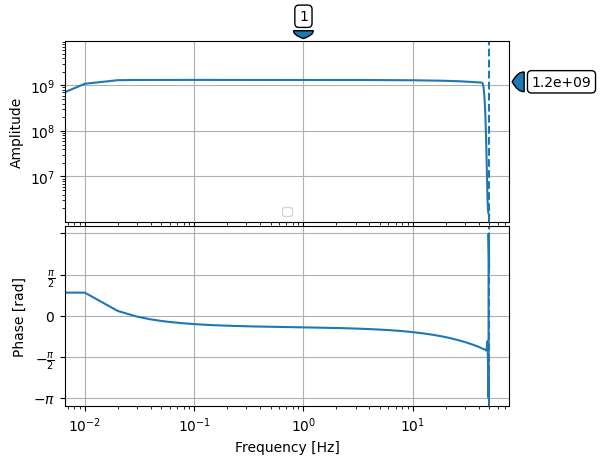

In [36]:
tmp.channels[1].response.plot(0.01);

In [34]:
tmp.__dict__

{'_latitude': 40.820065,
 '_longitude': 14.142049,
 '_elevation': 170.0,
 'channels': [Channel 'HHE', Location '' 
	Time range: 2011-12-09T23:00:00.000000Z - 2022-02-25T23:59:00.000000Z
	Latitude: 40.8201, Longitude: 14.1420, Elevation: 170.0 m, Local Depth: 0.0 m
	Azimuth: 90.00 degrees from north, clockwise
	Dip: 0.00 degrees down from horizontal
	Sampling Rate: 100.00 Hz
	Sensor (Description): None (GURALP CMG-40T-60S)
	Response information available,
  Channel 'HHE', Location '' 
	Time range: 2022-02-25T23:59:00.000000Z - --
	Latitude: 40.8201, Longitude: 14.1420, Elevation: 170.0 m, Local Depth: 0.0 m
	Azimuth: 90.00 degrees from north, clockwise
	Dip: 0.00 degrees down from horizontal
	Sampling Rate: 100.00 Hz
	Sensor (Description): None (GURALP CMG-3ESPC-120S)
	Response information available,
  Channel 'HHN', Location '' 
	Time range: 2011-12-09T23:00:00.000000Z - 2022-02-25T23:59:00.000000Z
	Latitude: 40.8201, Longitude: 14.1420, Elevation: 170.0 m, Local Depth: 0.0 m
	Azimuth:

In [24]:
tmp.channels[1].start_date

2013-01-31T00:00:00.000000Z

In [23]:
tmp.channels[1].response.instrument_sensitivity.value

243902000.0

In [ ]:
################################################################################
########## DO NOT USE !!!datetime.datetime.fromtimestamp(ev.time)!!! ##########
################################################################################

t = util.time_to_str(cat[0].time)
print(t)
UTCDateTime(t)-20


In [ ]:
for ev in cat:
    evID=ev.name

    #transform UTC time
    t = util.time_to_str(ev.time)

    print('origin UTC time event:',t)
    print('extimated magnitude:',ev.magnitude)

    event_start = UTCDateTime(t) - 20
    #print('event starts at:',event_start)

    event_end=UTCDateTime(t) +40
    #print('event ends at:',event_end)


    wave=Stream()
    for network in stations:
        for  station in network.stations:
            try:
                wave += client.get_waveforms(starttime=event_start,endtime=event_end,
                                    network=network.code,station=station.code,location='*', channel='HH?',
                                    attach_response=True)
            except:
                #print(station.code , 'station not recording')
                continue

    print('traces found:',len(wave.traces))

    waveletdir=os.path.join(datadir,evID)
    
    os.mkdir(waveletdir)

    wavelet_name= os.path.join(waveletdir,evID)  
    wave.write(wavelet_name +'.mseed',format='MSEED')
    print('saved!')